In [1]:
# mesa imports
from mesa_geo import GeoAgent, GeoSpace
from mesa.time import BaseScheduler
from mesa import datacollection
from mesa import Model

# shapely imports
from shapely.geometry import Polygon, Point, LineString
import shapely

# data analysis imports
import geopandas as gpd
import pandas as pd
import numpy as np

# plotting imports
import matplotlib as plt

# Introduction to Agent Based Modeling
Long things short, Agent Based Modeling is a type of model where a large amount of autonomous decision-making entities, called <b> agents </b>, follows certain pre-defined rules and interact with other agents to exhibit behaviors.

## Agents

Lets start with a simple agent that says hi each step

In [2]:
class NaiveAgent(GeoAgent):
    '''
    A simple geo-agent that only says "hi!" each step
    unique_id: the unique_id of the agent
    model: the model that the agent belongs to
    shape: the spatial shape of the agent
    '''
    def __init__(self, unique_id, model, shape):
        '''
        initialize the Naive Agent with required parameters, we would not necessarily use any of it at this point
        '''
        super().__init__(unique_id, model, shape)
        
        
        
    def step(self):
        print('hi!')

Let's create an agent at location (0,0)

In [3]:
unique_id = "na0"
model = None # we will get back to this later, current we do not have a model
shape = Point(0,0)
a = NaiveAgent(unique_id, model, shape)

We can call the `step` function deliberately 

In [4]:
a.step()

hi!


## Model
The model can be think of as the spatial location where the agents are based on <br>
Let's start with a simple `GeoSpace` model that intialize agents in random point within the x in [-10, 10), y in [-10, 10) square

In [5]:
class NaiveModel(Model):
    def __init__(self, agent_class, agent_N):
        '''
        initialize the model with a GeoSpace grid
        agent_class: the type of agent you want to initialize in this model
                     normally not an input parameter as models are mostly tied to specific agent types
                     here we want to reuse thi model later
        agent_N: number of agents to intialize the model with
        '''
        
        
        # mesa required attributes
        self.running = True # determines if model should keep on running
        # should be specified to false when given conditions are met
        
        self.grid = GeoSpace() # To learn more about other type of space grid, check mesa documentation
        self.schedule = BaseScheduler(self) # scheduler dictates model level agent behavior, aka. step function
        # Here we are using a BaseScheduler which computes step of the agents by order
        # To learn more about other type of scheduler, check mesa documentation
        
        
        # init agents
        for i in range(agent_N):
            pnt = Point(np.random.uniform(-10, 10), np.random.uniform(-10, 10))
            a = agent_class(model=self, shape=pnt, unique_id="na" + str(i))
            self.grid.add_agents(a)
            self.schedule.add(a)
        
        
        
    def step(self):
        '''
        step function of the model that would essentially call the step function of all agents
        '''
        self.schedule.step()
        self.grid._recreate_rtree() # this is some history remaining issue with the mesa-geo package
        # what this does is basically update the new spatial location of the agents to the scheduler deliberately

Now we can create a model with 10 naive agents in it

In [6]:
nmodel = NaiveModel(NaiveAgent, 10)

To run the model a single step, call `step` function 

In [7]:
nmodel.step()

hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!
hi!


You can also access all the agents of the model via model scheduler

In [8]:
agents = nmodel.schedule.agents

In [9]:
agents

You can access the shape (location) of the agents with their attribute `shape`, and as a result visualize it if necessary 

In [10]:
shapes = gpd.GeoSeries(map(lambda a: a.shape, agents))

<AxesSubplot:>

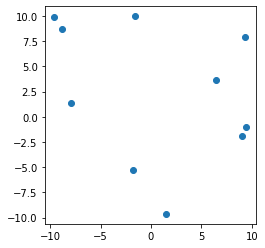

In [11]:
shapes.plot()

## Not So Naive Behavior

What if we want more complicated behaviors? <br>
Let's say you want agents to move by a random <b> (x, y) </b> each step, in the range of [-5,5), and perhaps <b> say "hi!" </b> to all other agents <b> within the distance of 2 </b>

`get_neighbors_within_distance` is a nice and efficient method you can use to check surrounding neighbors

In [46]:
class MobileAgent(NaiveAgent):
    '''
    A simple geo-agent that each step moves in the range of [-5,5) and greets all agents within 2 units
    unique_id: the unique_id of the agent
    model: the model that the agent belongs to
    shape: the spatial shape of the agent
    '''
    def __init__(self, unique_id, model, shape):
        super().__init__(unique_id, model, shape)
        self.greeted = False # some attribute to indicate if one agent has ever greeted another agent in its life-span
        
        # coordinate attributes
        # eventhough it is not ncessary to establish as attributes
        # setting as attribute would enhance data collection efficiency
        # check mesa documentation for more details in the DataCollector page
        self.x = self.shape.x
        self.y = self.shape.y
        
        
    def step(self):
        '''
        update the current location within the random range and greet to all surrounding neighbors with specified greet_dist
        
        '''
        self.x, self.y = self.x+np.random.uniform(-5,5), self.y+np.random.uniform(-5,5) # update the location
        self.shape = Point(self.x, self.y) # update shape
        self.__greet(2) # call greet function
    
    
    def __greet(self, greet_dist):
        '''
        say hi to all surrounding neighbors with specified greet_dist
        greet_dist: maiximum distance to greet to neighbors
        '''
        
        
        neighbors = self.model.grid.get_neighbors_within_distance(self, greet_dist)
        for neighbor in neighbors:
            if neighbor.unique_id != self.unique_id:
                print('Hi! Fellow agent ' + str(neighbor.unique_id) + ". I am " + str(self.unique_id))
                self.greeted = True # update the greeted indicator to True

With our previous naive model, we can run our new agent with the following:

In [47]:
mobile_model = NaiveModel(MobileAgent, 10)

Let's run 10 steps!

In [48]:
for _ in range(10):    
    mobile_model.step()

Hi! Fellow agent na9. I am na8
Hi! Fellow agent na6. I am na5
Hi! Fellow agent na2. I am na1
Hi! Fellow agent na4. I am na3
Hi! Fellow agent na9. I am na6
Hi! Fellow agent na2. I am na1
Hi! Fellow agent na6. I am na2
Hi! Fellow agent na9. I am na8
Hi! Fellow agent na3. I am na2
Hi! Fellow agent na8. I am na6


Remember `BaseScheduler` runs in order of the agents. So, agent `step` is not being called simultaneously, which explains why it is possible that there are no "greet backs" in the naive model run

Again, we can get access to agent locations with the scheduler

In [49]:
agents = mobile_model.schedule.agents

We can check the final location of the agents as well as who has greeted others 

In [50]:
greeted = gpd.GeoSeries(map(lambda a: a.shape, [agent for agent in agents if agent.greeted]))
not_greeted = gpd.GeoSeries(map(lambda a: a.shape, [agent for agent in agents if not agent.greeted]))

<AxesSubplot:>

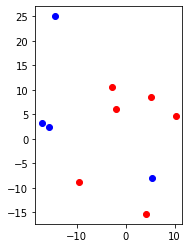

In [51]:
basemap = greeted.plot(c="red")
not_greeted.plot(c="blue", ax = basemap)

## Data Collection

What if you want to access the location as well as greeting status of each agents in each model step?

We have been accessing the agents via `model.schedule.agents` for all of our previous examples. However as you already noticed, that's really inefficient if you want to do so each step.

MESA provide a data collecting module called `DataCollector` that can collect the model data as well as the agent data at step level

In [52]:
class CollectableModel(NaiveModel):
    def __init__(self, agent_class, agent_N):
        '''
        initialize the model with a GeoSpace grid
        agent_class: the type of agent you want to initialize in this model
                     normally not an input parameter as models are mostly tied to specific agent types
                     here we want to reuse thi model later
        agent_N: number of agents to intialize the model with
        '''
        super().__init__(agent_class, agent_N)
        
        
        #data collect init
        # the model reporter specifies the data that should be collected from the model in each collect call
        # since we have no model data to be collected in this example, it is not specified
        # the format is the same as the agent_reporters
        
        # the agent reporter specifies the data that should be collected from the agents in each collect call
        agent_reporters = {"x": "x",
                           "y": "y",
                           "greet status": "greeted"}
        
        
        # both dictionaries can take in lambda function as well
        # however, for efficiency purposes, getting attribute is recommanded
        # check mesa documentation for more details in the DataCollector page
        
        
        self.datacollector = datacollection.DataCollector(agent_reporters=agent_reporters)#, model_reporters=model_reporters)
        
        
    def step(self):
        '''
        step function of the model that would essentially call the step function of all agents
        '''
        self.schedule.step()
        self.grid._recreate_rtree()
        self.datacollector.collect(self)

In [53]:
cmodel = CollectableModel(MobileAgent, 10)

Let's run 10 steps!

In [54]:
for _ in range(10):    
    cmodel.step()

Hi! Fellow agent na0. I am na8
Hi! Fellow agent na4. I am na2
Hi! Fellow agent na8. I am na5
Hi! Fellow agent na6. I am na1
Hi! Fellow agent na5. I am na2
Hi! Fellow agent na2. I am na0
Hi! Fellow agent na5. I am na3
Hi! Fellow agent na3. I am na5
Hi! Fellow agent na8. I am na5


We can get the data from the `DataCollector` with method `get_agent_vars_dataframe`

In [55]:
agent_data = cmodel.datacollector.get_agent_vars_dataframe()

In [56]:
agent_data

x         y  greet status
Step AgentID                                   
1    na0       1.554402 -8.629347         False
     na1      -4.259763  9.095215         False
     na2      12.020300 -2.537800         False
     na3      -2.358469 -1.737021         False
     na4       6.425213 -0.173311         False
...                 ...       ...           ...
10   na5       6.080076 -5.490210          True
     na6       4.630000  6.378335         False
     na7       8.531642  0.657554         False
     na8       4.342753 -7.961562          True
     na9     -20.588611  1.773098         False

[100 rows x 3 columns]

## Thank you for reading!

This is the end of this quickstart tutorial! <br>
Even though this quickstart only covers very naive functionality of MESA. I know from my experience that learning a new package from 0 is really hard. So I tried to make this notebook as readable as possible. Still, feel free to message me any question you have! <br>
<br>
-- Johnny
